# **Import necessary Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
import warnings
warnings.filterwarnings(action='ignore')

# **Get Dataset**

In [2]:
# mount drive folder to colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# get training predictor csv file
file = r"/content/drive/My Drive/IDA Project/IDA project dataset/train_x.csv"
 
# read csv using pandas 
data_x = pd.read_csv(file)
data_x.head()

,ID,Expense,Income,Loan type,Occupation type,Age,Score1,Score2,Score3,Score4,Score5
0,1,1830.943788,14767.28013,B,Y,1.0,0.016885,205.196182,22.521523,600.911200,3464.613291
1,2,1645.302546,15272.26775,B,Y,0.0,0.240375,194.266317,5.349117,600.888816,3374.921455
2,3,1555.026392,17482.49734,A,Y,0.0,0.213921,183.529871,-1.054954,598.596944,3331.304886
3,4,NaN,16257.66493,A,Y,0.0,0.303909,191.228965,6.971750,602.447203,3392.275849
4,5,1777.648916,16316.29914,B,X,1.0,NaN,224.074728,11.218489,605.947340,3438.864083


In [4]:
# get training target csv file
file_y = r"/content/drive/My Drive/IDA Project/IDA project dataset/train_y.csv"

# read csv using pandas 
data_y = pd.read_csv(file_y)
data_y.head()

,ID,Label
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


# **Data Preprocessing**

In [5]:
# replace whitespaces in feature names with an underscore
data_x.columns = [c.replace(' ', '_') for c in data_x.columns]

In [6]:
# Drop 'ID' column Since it only conveys the chronological order in which data was collected
data_x = data_x.drop(['ID'], axis=1)
data_y = data_y.drop(['ID'], axis=1)

In [7]:
# check variables data type
data_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Expense          77956 non-null  float64
 1   Income           78045 non-null  float64
 2   Loan_type        77989 non-null  object 
 3   Occupation_type  78141 non-null  object 
 4   Age              77986 non-null  float64
 5   Score1           78060 non-null  float64
 6   Score2           77964 non-null  float64
 7   Score3           78045 non-null  float64
 8   Score4           78028 non-null  float64
 9   Score5           78002 non-null  float64
dtypes: float64(8), object(2)
memory usage: 6.1+ MB


In [8]:
# Use one hot encoding to encode categorical variables and drop the first column  
cat_var = data_x[['Loan_type', 'Occupation_type']]
dummies = pd.get_dummies(data_x, prefix=['Loan_type', 'Occupation_type'], drop_first= True)
dummies.loc[data_x['Loan_type'].isnull(), dummies.columns.str.startswith("Loan_type_")] = np.nan
dummies.loc[data_x['Occupation_type'].isnull(), dummies.columns.str.startswith("Occupation_type_")] = np.nan
dummies.head()

,Expense,Income,Age,Score1,Score2,Score3,Score4,Score5,Loan_type_B,Occupation_type_Y,Occupation_type_Z
0,1830.943788,14767.28013,1.0,0.016885,205.196182,22.521523,600.911200,3464.613291,1.0,1.0,0.0
1,1645.302546,15272.26775,0.0,0.240375,194.266317,5.349117,600.888816,3374.921455,1.0,1.0,0.0
2,1555.026392,17482.49734,0.0,0.213921,183.529871,-1.054954,598.596944,3331.304886,0.0,1.0,0.0
3,NaN,16257.66493,0.0,0.303909,191.228965,6.971750,602.447203,3392.275849,0.0,1.0,0.0
4,1777.648916,16316.29914,1.0,NaN,224.074728,11.218489,605.947340,3438.864083,1.0,0.0,0.0


In [9]:
# check target variable datatype
data_y.info()

# check for duplicate 
data_x.duplicated().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Label   76097 non-null  float64
dtypes: float64(1)
memory usage: 625.1 KB


False

In [10]:
# split data into train and test to train and evaluate the model
X_train, X_test, y_train, y_test = train_test_split(dummies, data_y, test_size=0.2, random_state=42)
X2_train=np.append(X_train,y_train,axis=1) 
X2_test=np.append(X_test,y_test,axis=1)
cols = ['Expense', 'Income', 'Age', 'Score1', 'Score2', 'Score3', 'Score4',
       'Score5', 'Loan_type_B', 'Occupation_type_Y', 'Occupation_type_Z', 'label']
X2_train = pd.DataFrame(X2_train, columns = cols)
X2_test = pd.DataFrame(X2_test, columns = cols)

In [11]:
# Normalize the data such that all features lie in same range [0,1]
# KNN imputer performs best with normalized data as all the features equally affect the distance metric.
from sklearn.preprocessing import MinMaxScaler
cols_to_norm = ['Expense', 'Income', 'Age', 'Score1', 'Score2', 'Score3', 'Score4', 'Score5']
minmaxscaler = MinMaxScaler()
X2_train[cols_to_norm] = pd.DataFrame(minmaxscaler.fit_transform(X2_train[cols_to_norm]), columns = cols_to_norm)
X2_test[cols_to_norm] = pd.DataFrame(minmaxscaler.transform(X2_test[cols_to_norm]), columns = cols_to_norm)
X2_train.head()

,Expense,Income,Age,Score1,Score2,Score3,Score4,Score5,Loan_type_B,Occupation_type_Y,Occupation_type_Z,label
0,0.327993,0.454232,0.0,0.560177,0.453913,0.351965,0.391059,0.329711,NaN,0.0,1.0,NaN
1,0.348870,0.556629,1.0,0.742426,0.553143,0.370068,0.597193,0.350697,1.0,0.0,0.0,0.0
2,NaN,0.489403,0.0,0.604372,0.437175,0.468926,0.458450,0.522616,0.0,1.0,0.0,0.0
3,0.579462,0.466040,0.0,0.430114,0.410756,0.542739,0.349934,0.582496,0.0,0.0,1.0,1.0
4,0.421201,0.526440,0.0,0.593642,0.430227,0.402546,0.422684,0.423407,0.0,1.0,0.0,0.0


In [12]:
# missing values imputed using the attributes that are most similar to the attribute whose values are missing.
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
X2_train = pd.DataFrame(imputer.fit_transform(X2_train),columns = X2_train.columns)
X2_test = pd.DataFrame(imputer.transform(X2_test),columns = X2_test.columns)

In [13]:
# changing the data type of target variable from continuous to integer type (0 or 1)
X2_train['label'] = X2_train['label'].astype('int')
X2_test['label'] = X2_test['label'].astype('int')

In [14]:
# defining train and test target and predictor variables
y_train = X2_train[['label']]
y_test = X2_test[['label']]
X_train = X2_train.drop(['label'], axis=1)
X_test = X2_test.drop(['label'], axis=1)

In [15]:
# Use OneClassSVM to predict outlier data points for binary classifier
from sklearn.svm import OneClassSVM
ee = OneClassSVM(nu=0.01)
yhat = ee.fit_predict(X_train)
X_train = X_train[yhat == 1]
y_train = y_train[yhat == 1]

In [16]:
# Scaling train dataset such that all the features have zero mean and unit variance 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Hyperparameter Tuning of individual best models**

In [ ]:
# SVC parameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
  
# defining parameter range 
param_dist = {'C': [0.1, 1, 10, 100],  
              'gamma': ['scale', 'auto'], 
              'kernel': ["linear", "rbf", "poly"],
              'probability': [True, False],
              'degree': [1,3,5]}  
  
svc_cv = RandomizedSearchCV(SVC(), param_dist, cv = 5, n_jobs = -1) 
  
# fitting the model for random search 
svc_cv.fit(X_train, y_train) 
print(svc_cv.best_params_)
print(svc_cv.best_score_)

{'probability': True, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 1, 'C': 100}
0.984738005050505


In [ ]:
# MLP parameter tuning
from sklearn.model_selection import RandomizedSearchCV

  
# defining parameter range 
param_dist = parameter_space = {
    'hidden_layer_sizes': [(10,10,10), (50,50,50), (50,100,50), (100,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.05, 0.1],
    'max_iter': [200, 2000],
    'learning_rate': ['constant','adaptive']
}
  
mlp_cv = RandomizedSearchCV(MLPClassifier(), param_dist, cv = 5, n_jobs = -1) 
  
# fitting the model for random search 
mlp_cv.fit(X_train, y_train) 
print(mlp_cv.best_params_)
print(mlp_cv.best_score_)

{'solver': 'lbfgs', 'max_iter': 200, 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.05, 'activation': 'tanh'}
0.9889362373737374


In [ ]:
# Random forest Hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
# using cross validation 
# define parameter range
param_dist = { 'criterion': ['gini', 'entropy'],
 'bootstrap': [True, False],
 'max_depth': [3, 5, None],
 'max_features' : ['auto', 'sqrt', 'log2', None],
 'min_samples_leaf': [1, 3, 4, 5],
 'min_samples_split': [2, 5, 10, 20],
 'n_estimators': [50,100,200],
 'class_weight': ['balanced', 'balanced_subsample', None]
 }

clf = RandomForestClassifier() 
tree_cv = RandomizedSearchCV(clf, param_dist, cv = 5, n_jobs = -1)

# fitting the model for random search
tree_cv.fit(X_train,y_train)
print(tree_cv.best_params_)
print(tree_cv.best_score_)

{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': None, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'bootstrap': True}
0.9837594696969697


# **Stacking Classifier (meta classifier with stacked hypertuned classifiers)**

In [20]:
from sklearn.svm import SVC, NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


# Initializing Support Vector classifier
classifier1 = SVC(C = 100, degree = 1, gamma = "scale", kernel = "rbf", probability = True, class_weight= None)

# Initializing Multi-layer perceptron  classifier
classifier2 = MLPClassifier(solver = 'lbfgs', activation = "tanh", alpha = 0.05, hidden_layer_sizes = (100,),
                            learning_rate = "constant", max_iter = 200, random_state = 1000)

# Initializing Random Forest classifier
classifier3 = RandomForestClassifier(n_estimators=100, max_depth = None, min_samples_leaf= 3, min_samples_split= 2, max_features= None, criterion = 'entropy', class_weight= 'balanced_subsample', bootstrap = True, random_state=0)


In [21]:
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import StackingClassifier
# Initializing the StackingCV classifier
sclf = StackingClassifier((("SVC", classifier1),("MLP", classifier2), ("RF", classifier3)), cv = 5, final_estimator =  SVC(probability = True))

In [20]:
# fit the meta classifier on train dataset 
sclf.fit(X_train, y_train)
# predict labels for test dataset
sclf_pred = sclf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, sclf_pred)*100)

Accuracy: 99.0125


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, sclf_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14935
           1       0.93      0.92      0.93      1065

    accuracy                           0.99     16000
   macro avg       0.96      0.96      0.96     16000
weighted avg       0.99      0.99      0.99     16000



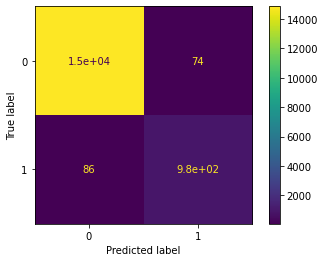

In [24]:
# plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(sclf, X_test, y_test) 
 

In [ ]:
from sklearn.model_selection import cross_val_score
from statistics import *
print(mean(cross_val_score(sclf, X_train, y_train, cv=5)))

0.9893150252525252


In [ ]:
sclf_pred = sclf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train, sclf_pred)*100)

Accuracy: 99.16666666666667


# **Predicting test_x**

In [25]:
# get csv file
file = r"/content/drive/My Drive/IDA Project/IDA project dataset/test_x.csv"

# read csv using pandas 
test_x = pd.read_csv(file)
test_x.head()

,ID_Test,Expense,Income,Loan type,Occupation type,Age,Score1,Score2,Score3,Score4,Score5
0,1,1780.356350,16691.51975,B,X,1,0.348808,226.896383,12.506668,607.396052,3440.172169
1,2,1939.547945,14782.20015,A,Z,0,0.426270,125.046903,12.976712,599.808710,3517.084962
2,3,1721.876977,14035.40923,B,Z,0,0.097577,181.636946,5.501962,596.344664,3411.918090
3,4,1681.268538,15179.79116,A,Z,0,0.295460,151.320572,3.058352,597.761361,3392.298282
4,5,1654.495928,15187.09603,A,Y,0,0.272479,178.429450,4.571414,600.006307,3379.363201


In [26]:
test_x.columns = [c.replace(' ', '_') for c in test_x.columns]

In [27]:
# remove test ID column
test_x = test_x.drop(['ID_Test'], axis=1)

In [28]:
test_x.head()

,Expense,Income,Loan_type,Occupation_type,Age,Score1,Score2,Score3,Score4,Score5
0,1780.356350,16691.51975,B,X,1,0.348808,226.896383,12.506668,607.396052,3440.172169
1,1939.547945,14782.20015,A,Z,0,0.426270,125.046903,12.976712,599.808710,3517.084962
2,1721.876977,14035.40923,B,Z,0,0.097577,181.636946,5.501962,596.344664,3411.918090
3,1681.268538,15179.79116,A,Z,0,0.295460,151.320572,3.058352,597.761361,3392.298282
4,1654.495928,15187.09603,A,Y,0,0.272479,178.429450,4.571414,600.006307,3379.363201


In [29]:
# check for null values
test_x.isnull().sum()

Expense            0
Income             0
Loan_type          0
Occupation_type    0
Age                0
Score1             0
Score2             0
Score3             0
Score4             0
Score5             0
dtype: int64

In [30]:
# Use one hot encoding to encode categorical variables and drop the first column 
cat_var = test_x[['Loan_type', 'Occupation_type']]
dummies = pd.get_dummies(test_x, prefix=['Loan_type', 'Occupation_type'], drop_first=True)
dummies.loc[test_x['Loan_type'].isnull(), dummies.columns.str.startswith("Loan_type_")] = np.nan
dummies.loc[test_x['Occupation_type'].isnull(), dummies.columns.str.startswith("Occupation_type_")] = np.nan
dummies.head()

,Expense,Income,Age,Score1,Score2,Score3,Score4,Score5,Loan_type_B,Occupation_type_Y,Occupation_type_Z
0,1780.356350,16691.51975,1,0.348808,226.896383,12.506668,607.396052,3440.172169,1.0,0.0,0.0
1,1939.547945,14782.20015,0,0.426270,125.046903,12.976712,599.808710,3517.084962,0.0,0.0,1.0
2,1721.876977,14035.40923,0,0.097577,181.636946,5.501962,596.344664,3411.918090,1.0,0.0,1.0
3,1681.268538,15179.79116,0,0.295460,151.320572,3.058352,597.761361,3392.298282,0.0,0.0,1.0
4,1654.495928,15187.09603,0,0.272479,178.429450,4.571414,600.006307,3379.363201,0.0,1.0,0.0


In [31]:
# transform the test data such that all features lie in same range [0,1] relative to the train data
test_x = dummies
test_x[cols_to_norm] = pd.DataFrame(minmaxscaler.transform(test_x[cols_to_norm]), columns = cols_to_norm)
test_x.head()

,Expense,Income,Age,Score1,Score2,Score3,Score4,Score5,Loan_type_B,Occupation_type_Y,Occupation_type_Z
0,0.543470,0.577555,1.0,0.718747,0.577433,0.520151,0.658119,0.546316,1.0,0.0,0.0
1,0.680912,0.377777,0.0,0.779786,0.190319,0.526058,0.445969,0.684478,0.0,0.0,1.0
2,0.492980,0.299638,0.0,0.520781,0.405409,0.432126,0.349111,0.495562,1.0,0.0,1.0
3,0.457920,0.419378,0.0,0.676709,0.290181,0.401419,0.388723,0.460318,0.0,0.0,1.0
4,0.434805,0.420143,0.0,0.658601,0.393217,0.420433,0.451494,0.437082,0.0,1.0,0.0


In [32]:
# scale test dataset realtive to train data
test_x = scaler.transform(test_x)

In [53]:
# predict the labels for the test dataset using meta classifier
y_pred = sclf.predict(test_x)

In [54]:
# convert into pandas dataframe
y_pred = pd.DataFrame(y_pred, columns= ['Label'])

In [59]:
y_pred.head()

,Label
1,0
2,0
3,0
4,0
5,0


In [58]:
# dataframe index starting from 1
y_pred.index = y_pred.index+1

In [61]:
# save as .csv file
y_pred.to_csv('y_pred.csv', index = True, index_label = 'ID')